In [90]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
# library(themis)

In [91]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


# Load our dataset
chest_pain_data <- read_csv(url, col_name = FALSE)
slice(chest_pain_data,1:6)

set.seed(1000)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [92]:
# add colomn names
names(chest_pain_data) <- c("age", "sex",
                         "chest_pain_type",
                         "trest_bps",
                          "cholesterol",
                          "fasting_blood_sugar",
                          "resting_ecg",
                          "max_heart_rate",
                          "exercise_induced_angina",
                          "oldpeak",
                          "slope",
                          "no_vessels_colored",
                          "thal",
                          "healthy")

# select columns we're using and convert chest_pain_type to factor
chest_pain_data <- select(chest_pain_data, age, chest_pain_type, trest_bps, cholesterol, max_heart_rate) %>%
    mutate(chest_pain_type = as_factor(chest_pain_type))

slice(chest_pain_data,1:6)

age,chest_pain_type,trest_bps,cholesterol,max_heart_rate
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
63,1,145,233,150
67,4,160,286,108
67,4,120,229,129
37,3,130,250,187
41,2,130,204,172
56,2,120,236,178


In [93]:
# split our dataset into a training dataset and a testing dataset
# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of fruit names in the dataset.

chest_pain_data_split <- initial_split(chest_pain_data, prop = 0.75, strata =chest_pain_type )  
chest_pain_data_train <- training(chest_pain_data_split)   
chest_pain_data_test <- testing(chest_pain_data_split)

slice(chest_pain_data_train,1:6) 
slice(chest_pain_data_test,1:6) 

age,chest_pain_type,trest_bps,cholesterol,max_heart_rate
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
67,4,160,286,108
37,3,130,250,187
41,2,130,204,172
56,2,120,236,178
62,4,140,268,160
57,4,120,354,163


age,chest_pain_type,trest_bps,cholesterol,max_heart_rate
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
63,1,145,233,150
67,4,120,229,129
53,4,140,203,155
52,3,172,199,162
49,2,130,266,171
58,2,120,284,160


In [94]:
# cross validation
vfold <- vfold_cv(chest_pain_data_train, v=5, strata = chest_pain_type)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.46666667
kap,multiclass,0.07149489


          Truth
Prediction  1  2  3  4
         1  0  0  0  0
         2  0  0  1  2
         3  1  5  7  6
         4  4  5 16 28

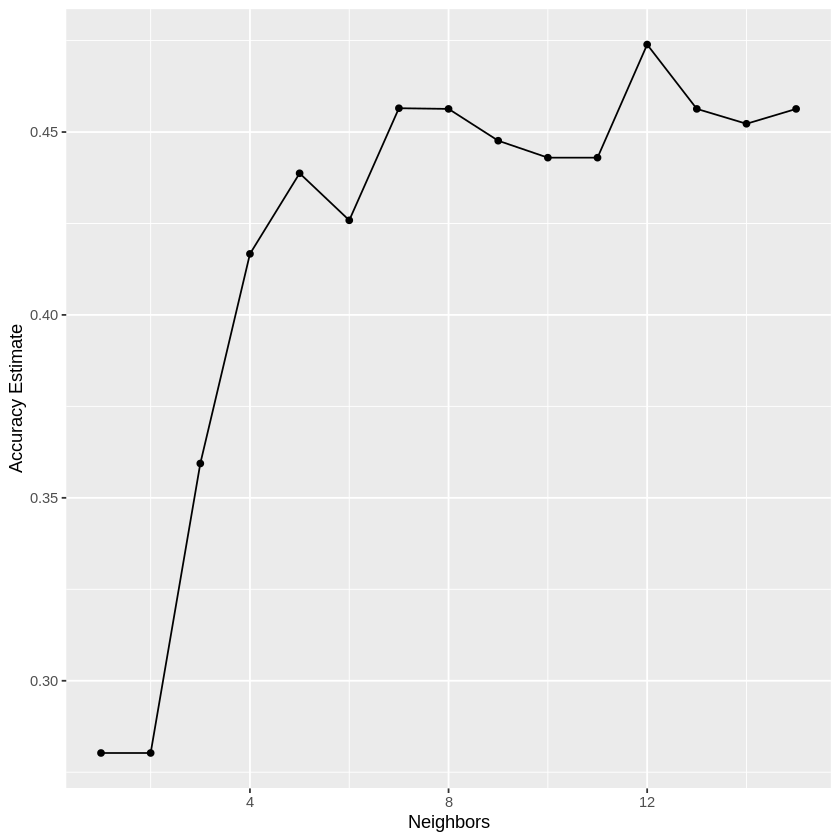

In [95]:
# recipe and standardization
cp_recipe <- recipe(chest_pain_type~age+trest_bps+cholesterol+max_heart_rate, data = chest_pain_data_train) %>%
  #  step_upsample(Class, over_ratio = 1, skip = FALSE) %>%         # fix imbalances
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# workflow
knn_result <- workflow() %>%
    add_recipe(cp_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = vfold, grid = 50) %>%
    collect_metrics()

# accuracy
accuracies <- knn_result %>%
    filter(.metric == "accuracy")

# accuracy plot
cross_val_plot <- accuracies %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point()+
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate")
cross_val_plot

# build model with k=12
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# new workflow
fit <- workflow() %>%
    add_recipe(cp_recipe) %>%
    add_model(knn_spec) %>%
    fit(data=chest_pain_data_train)

# predict
cp_predictions <- predict(fit, chest_pain_data_test) %>%
    bind_cols(chest_pain_data_test)

# compute accuracy
metrics <- cp_predictions %>%
    metrics(truth = chest_pain_type, estimate = .pred_class)
metrics

# confusion matrix
confusion <- cp_predictions %>%
    conf_mat(truth = chest_pain_type, estimate = .pred_class)
confusion